In [92]:
import scanpy as sc
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
import warnings
warnings.filterwarnings('ignore')

In [64]:
from utils.filehandling import buildGeneset
from utils.clustering import *
from utils.optimization import *

In [36]:
adata = sc.read("datasets/immune_adata.h5ad")

In [37]:
with open('Genesets/Immune/BCELLS.json', 'r') as file:
    bcell_gene_set = json.load(file)
    bcell_gene_set = bcell_gene_set['genes']
    
with open('Genesets/Immune/TCELLS.json', 'r') as file:
    tcell_gene_set = json.load(file)
    tcell_gene_set = tcell_gene_set['genes']
    
with open('Genesets/Immune/MPHAGES.json','r') as file:
    mphages_gene_set = json.load(file)
    mphages_gene_set = mphages_gene_set['genes']
    
    
bcell_gene_set_final = set(adata.var_names) & set(bcell_gene_set)
print(f"Genes removed from the gene set: {len(set(bcell_gene_set) - bcell_gene_set_final)} out of {len(bcell_gene_set)}\n")

tcell_gene_set_final = set(adata.var_names) & set(tcell_gene_set)
print(f"Genes removed from the gene set: {len(set(tcell_gene_set) - tcell_gene_set_final)} out of {len(tcell_gene_set)}\n")

mphages_gene_set_final = set(adata.var_names) & set(mphages_gene_set)
print(f"Genes removed from the gene set: {len(set(mphages_gene_set) - mphages_gene_set_final)} out of {len(mphages_gene_set)}\n")

Genes removed from the gene set: 2 out of 34

Genes removed from the gene set: 2 out of 19

Genes removed from the gene set: 1 out of 33



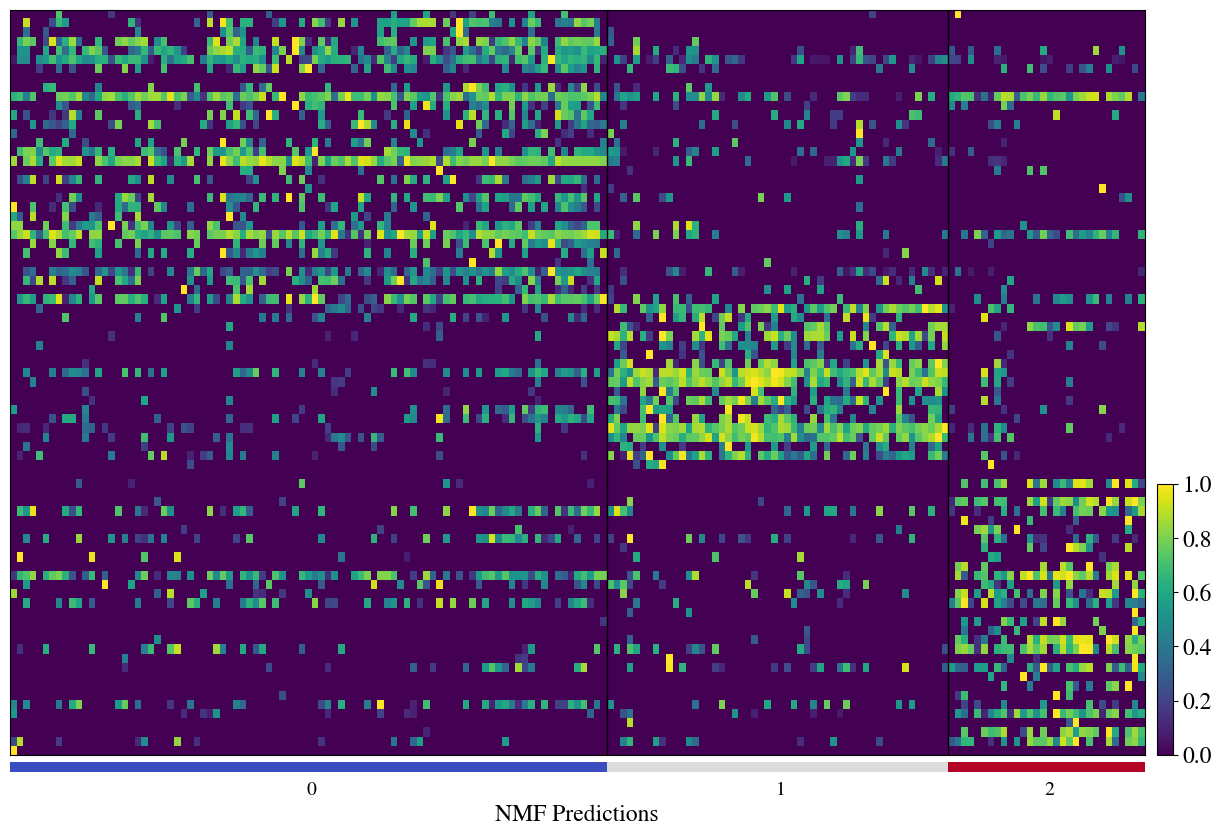

In [19]:
total_genes = list(bcell_gene_set_final) + list(tcell_gene_set_final) + list(mphages_gene_set_final)
adata = adata[:,total_genes]
sc.pl.heatmap(adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

From the above its evident that the cluster with label 0 expresses the BCELL related geneset, cluster 1 expresses the TCELL related geneset and cluster 2 expresses the Macrophage related geneset. Thus we can name the clusters accordingly.

In [39]:
adata.obs['NMF Predictions']

BC02_60       2
BC03_03       0
BC03_06       0
BC03_24       0
BC03_25       1
             ..
BC09_Re_94    1
BC09_Re_95    1
BC10_07       2
BC10_43       2
BC11_28       1
Name: NMF Predictions, Length: 173, dtype: category
Categories (3, object): ['0', '1', '2']

In [40]:
label_mapping = {'0': "B-CELL", '1': "T-CELL", '2': "MP-CELL"}
adata.obs['NMF Predictions'] = [label_mapping[label] for label in adata.obs['NMF Predictions']]

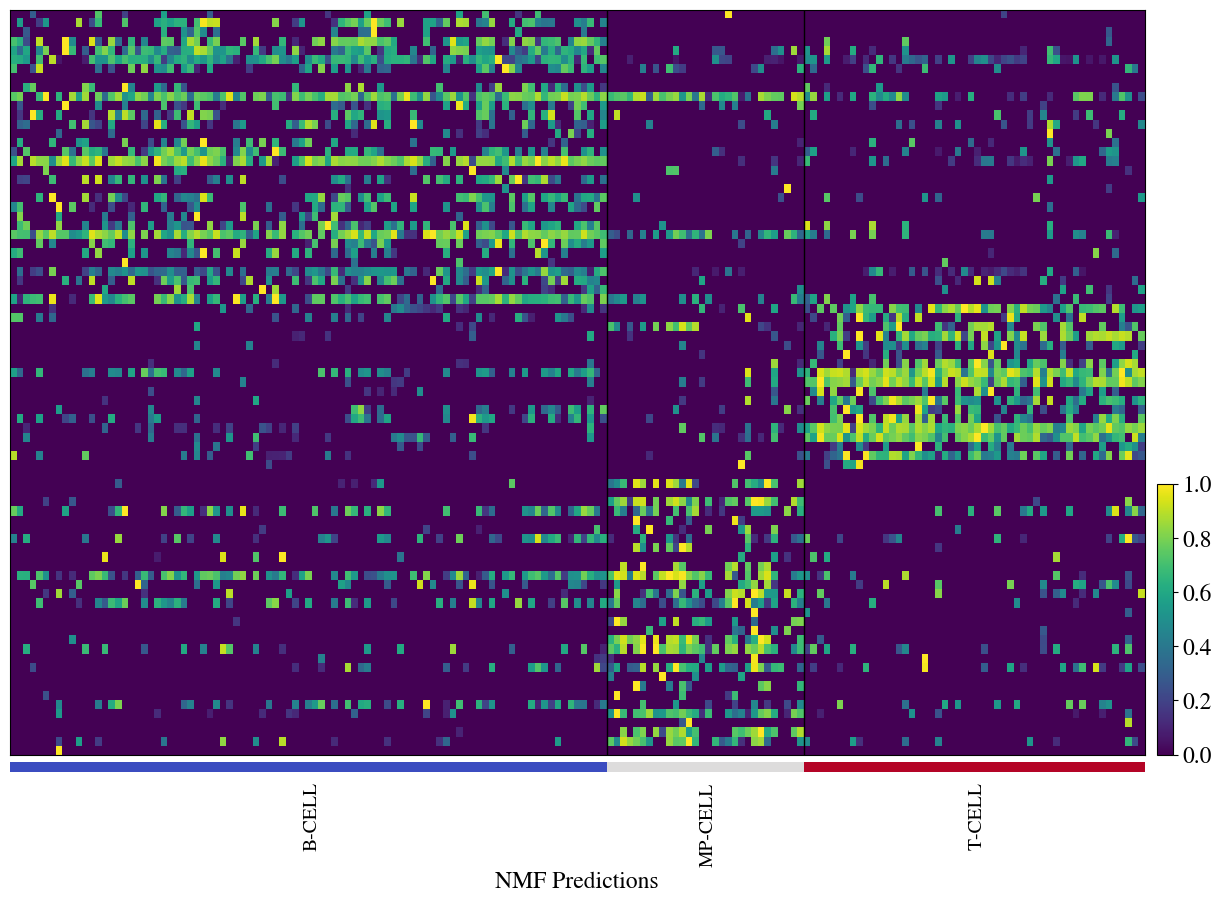

In [22]:
sc.pl.heatmap(adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

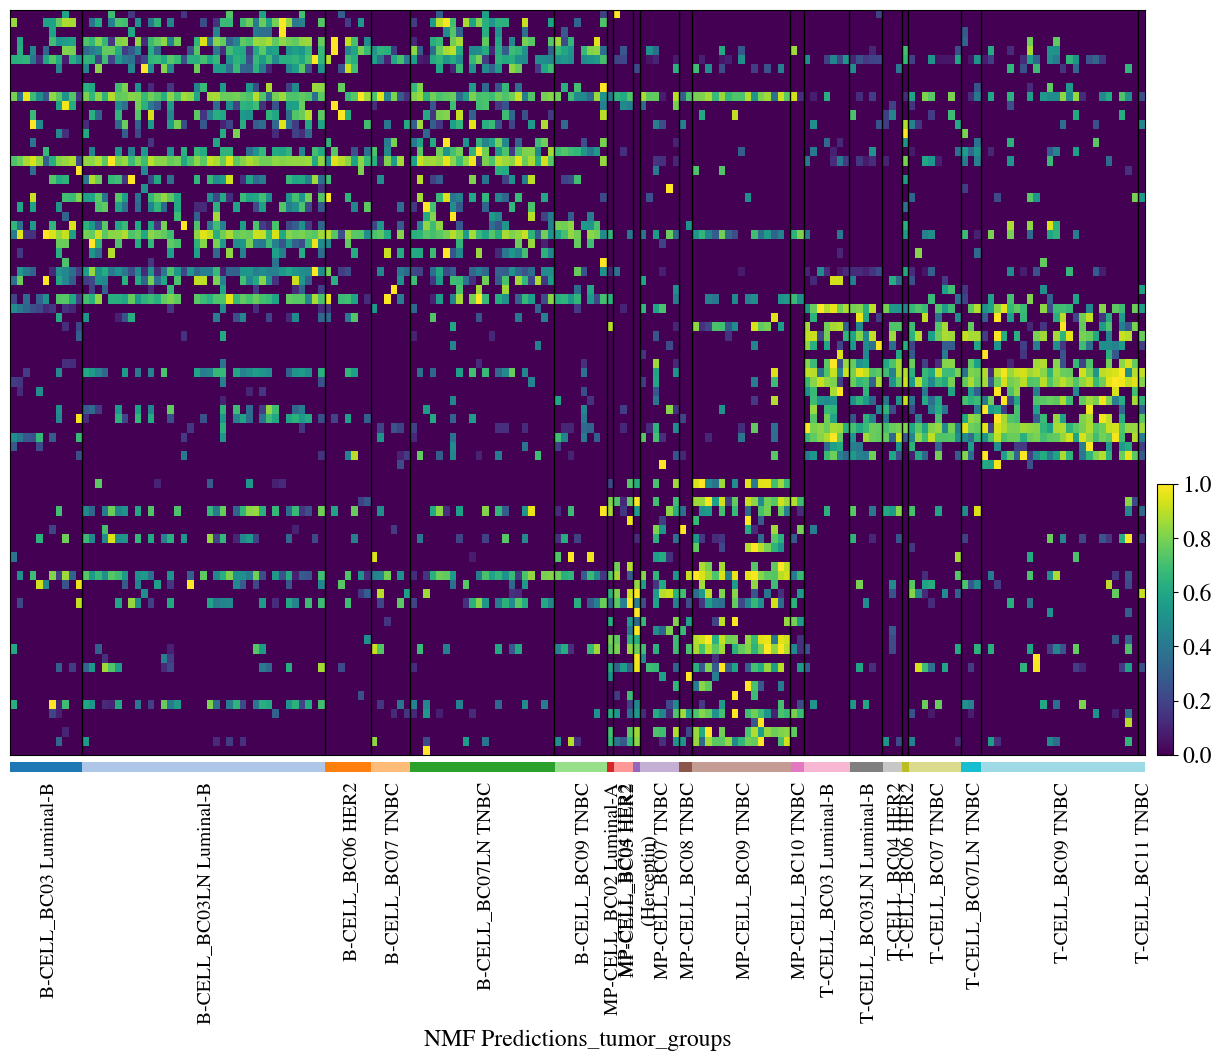

In [23]:
sc.pl.heatmap(adata, var_names=total_genes , groupby=['NMF Predictions','tumor_groups'], use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

# **T-cell singnature pathway Clustering** 

Genes removed from the gene set: 0 out of 6

Genes removed from the gene set: 0 out of 7

Genes removed from the gene set: 0 out of 6

Genes removed from the gene set: 0 out of 43

Genes removed from the gene set: 0 out of 55

Genes removed from the gene set: 0 out of 4

Genes removed from the gene set: 0 out of 7



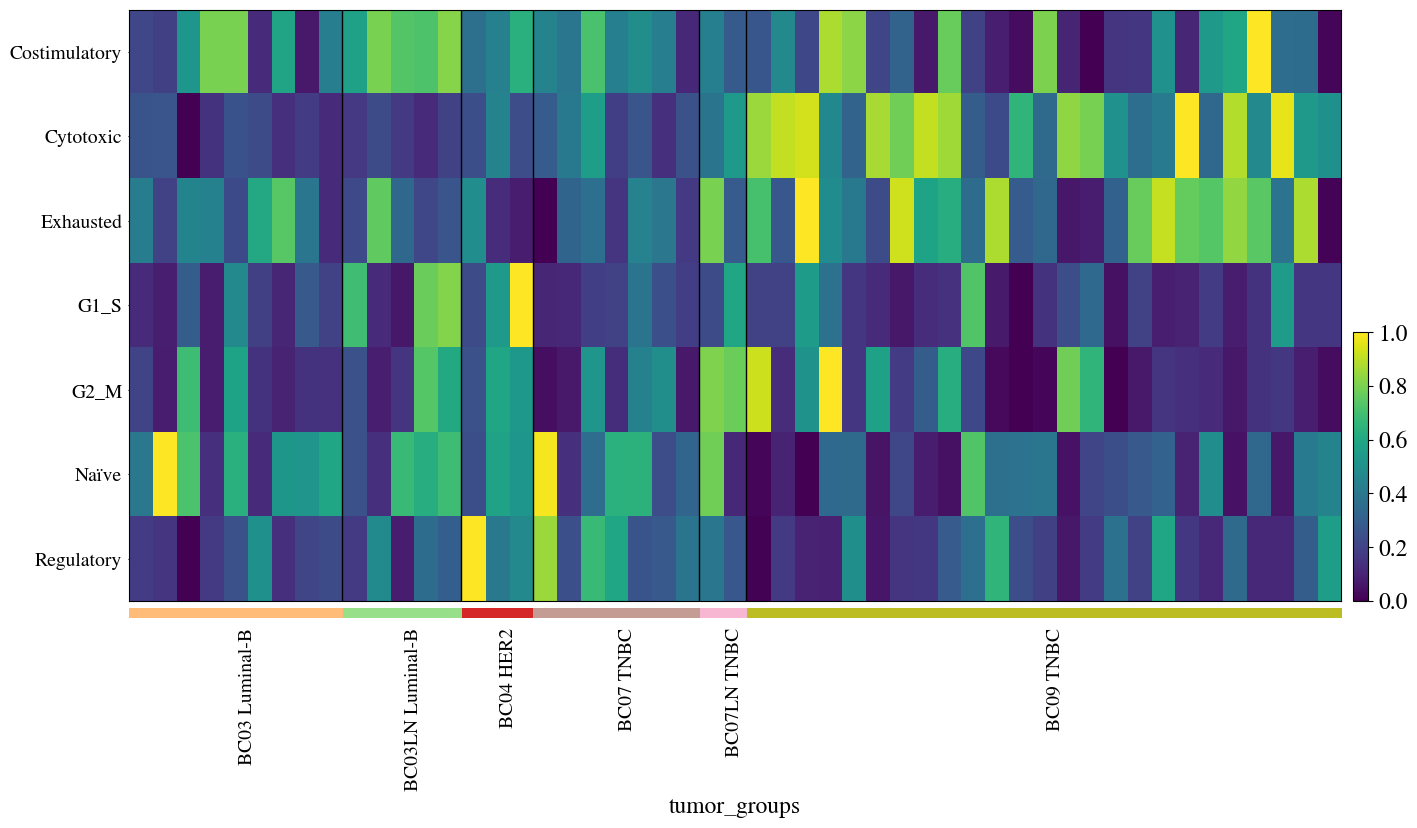

In [56]:
total_genes=[]
gene_sets = buildGeneset('Genesets/Tcells/',adata)
for key in gene_sets.keys():
  total_genes = total_genes + list(gene_sets[key])
  # For single cell data
  sc.tl.score_genes(adata,gene_sets[key],score_name = key)
    
adata_tcells = adata[adata.obs['Ground cell type']=='Tcell', total_genes]

# Plot scingle cell data
sc.pl.heatmap(
    adata_tcells,
    var_names=list(gene_sets.keys()),
    groupby="tumor_groups",
    swap_axes=True,
    standard_scale='var',
    vmin=0,
    vmax=1,
    figsize=(16, 8)
)

### **Hierarchical: Average linkage**

In [65]:
data = adata_tcells.X

The silhouete score in the optimal PCA space is: 0.14679360508689562


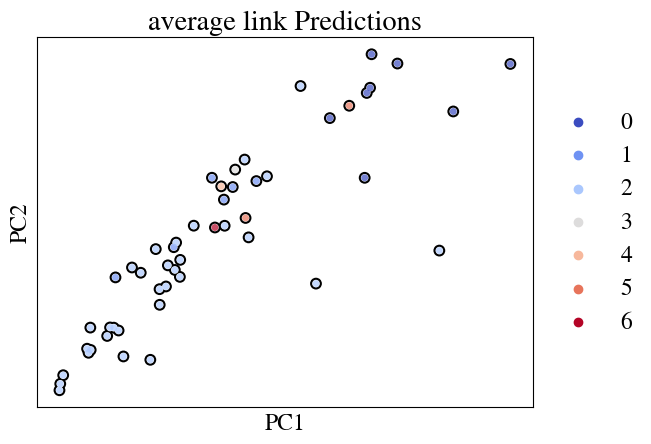

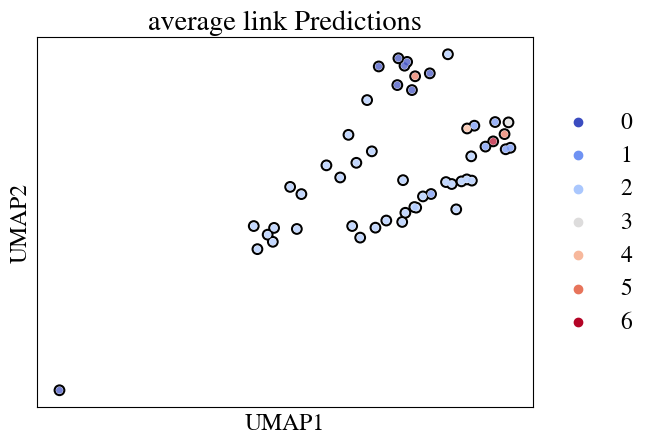

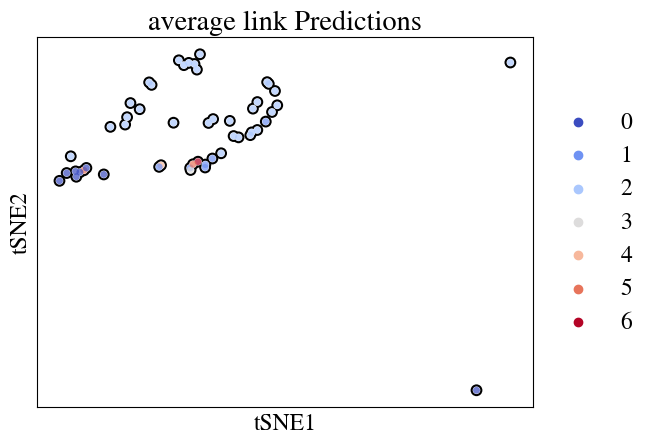

In [90]:
ha_score = hierarchical(data,adata_tcells,'average',n_clusters=7,compare=False)

## **Spectral Clustering**

In [76]:
def Spectral_trial(trial):
  n_neighbors = trial.suggest_int("n_neighbors",2,50)
  spectral = SpectralClustering(n_clusters=7,
                                affinity='nearest_neighbors',
                                n_neighbors=n_neighbors,
                                assign_labels="cluster_qr",
                                random_state=10)
  labels = spectral.fit_predict(data)
  try:
    return silhouette_score(data, labels, random_state=42)
  except ValueError:
  # Return the worst score if it does not converge
    return -1

pruner = optuna.pruners.HyperbandPruner()
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(Spectral_trial, n_trials=100, show_progress_bar=True)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value
print(best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

{'n_neighbors': 6}


The silhouete score in the optimal PCA space is: 0.059476739959828925


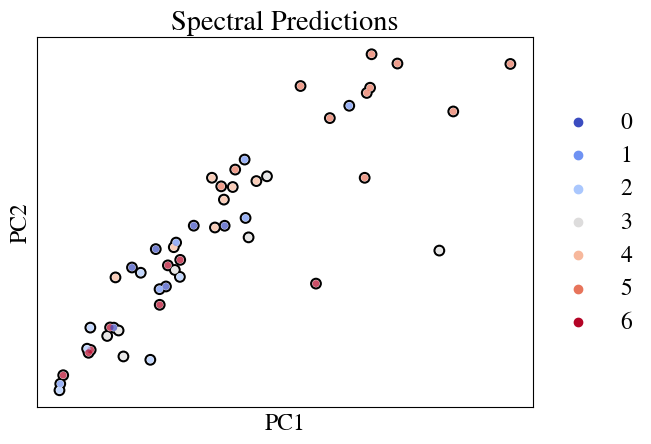

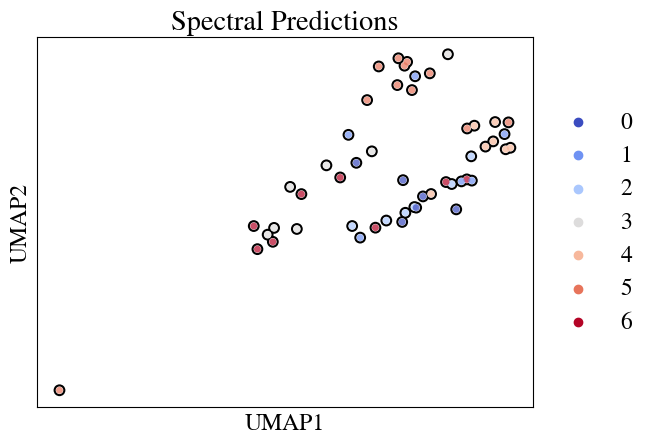

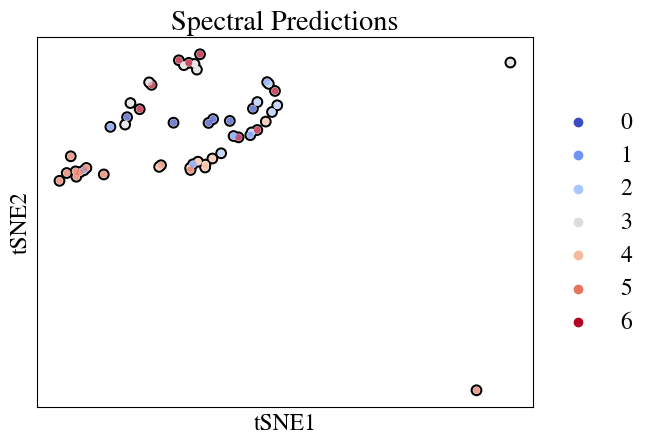

In [78]:
sp_score = spectral(data,adata_tcells,n_neighbors=best_params['n_neighbors'],comparison_key='Ground cell type',n_clusters= 7,compare=False)

### Hierarchical complete linkage

The silhouete score in the optimal PCA space is: 0.09904566435617919


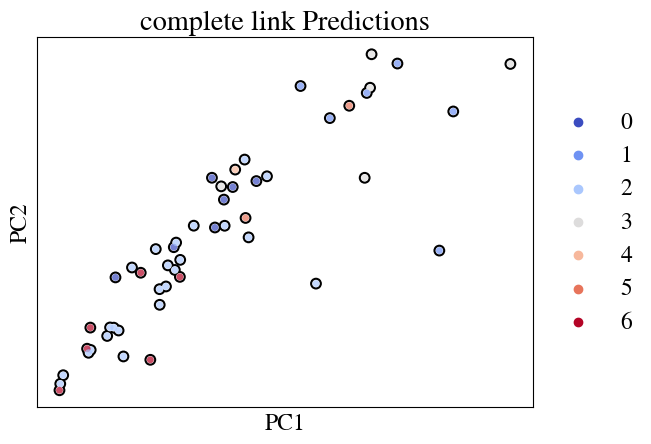

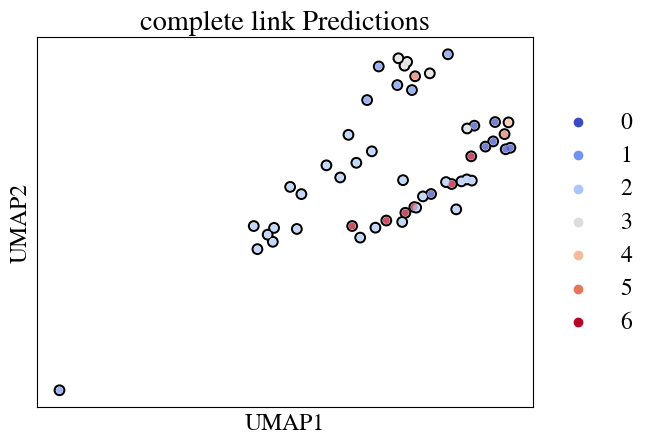

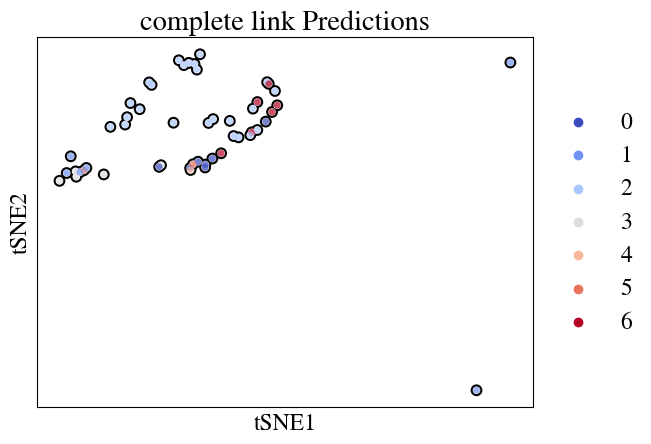

In [87]:
hc_score = hierarchical(data,adata_tcells,'complete',n_clusters=7,compare=False)

The silhouete score in the optimal PCA space is: 0.041847946520085576


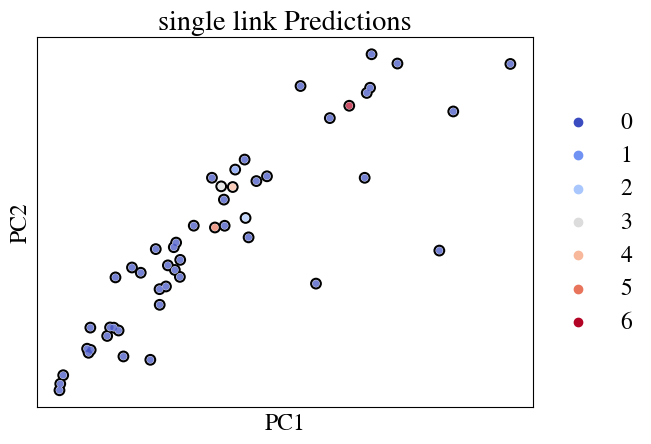

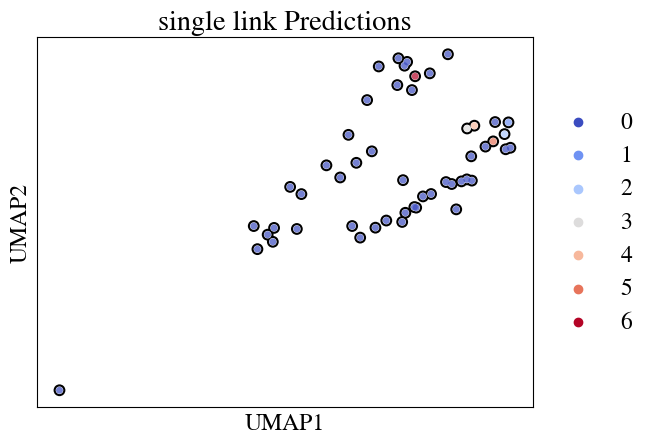

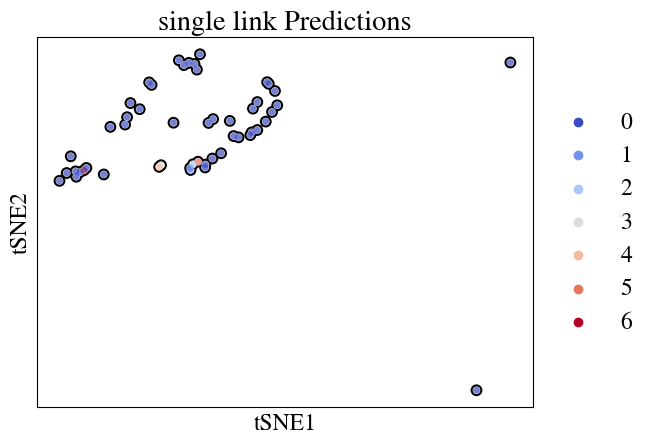

In [88]:
hs_score = hierarchical(data,adata_tcells,'single',n_clusters=7,compare=False)

The silhouete score in the optimal PCA space is: 0.057797832912104996


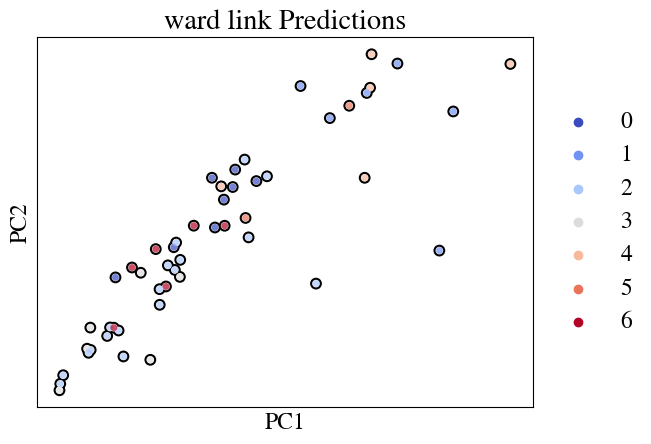

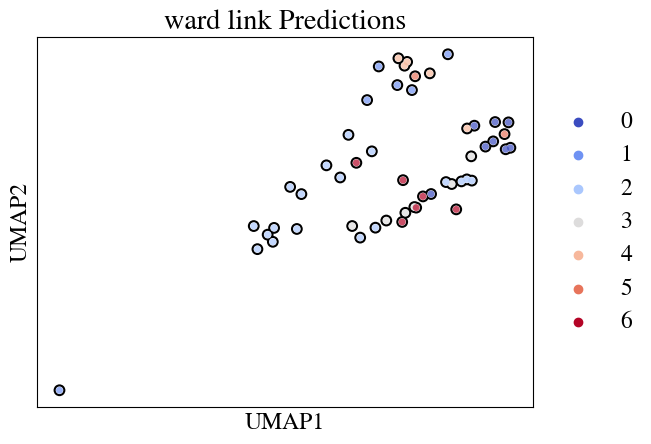

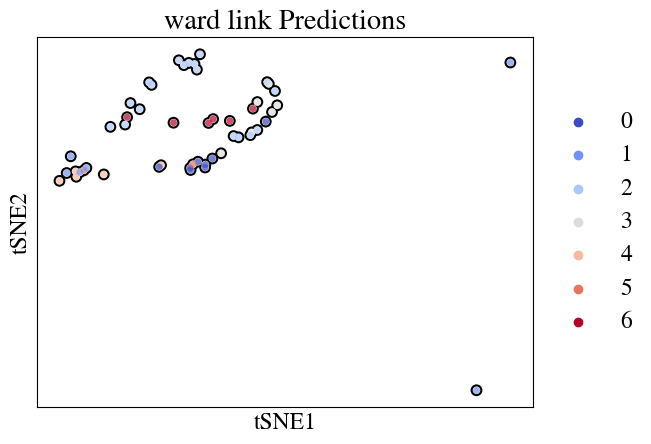

In [89]:
hw_score = hierarchical(data,adata_tcells,'ward',n_clusters=7,compare=False)

# **Results of T-cell signature seperation**

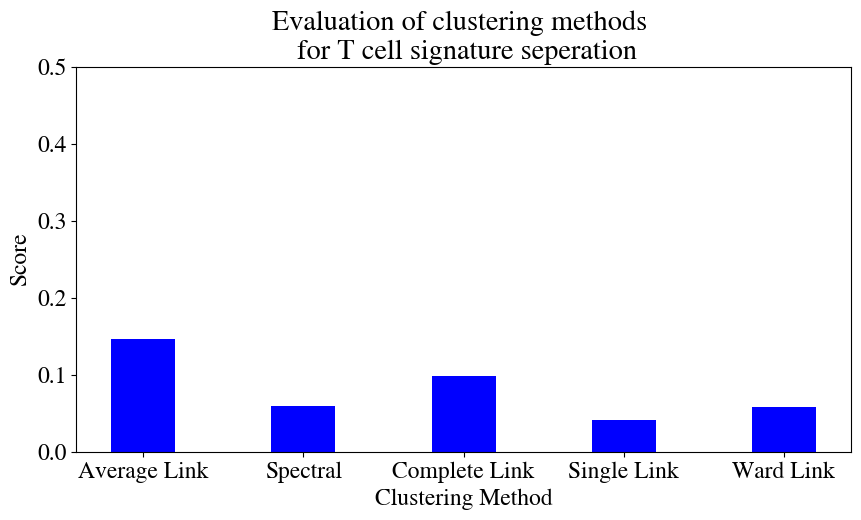

In [101]:
results_df = pd.DataFrame({'Method':['Average Link','Spectral','Complete Link','Single Link','Ward Link'],
                        'Silhouette Score':[ha_score,sp_score, hc_score, hs_score, hw_score]})
                        

plt.figure(figsize=(10,5))
plt.bar(x = results_df['Method'], height = results_df['Silhouette Score'], color = 'blue', width = 0.4)
plt.title("Evaluation of clustering methods \n for T cell signature seperation")
plt.ylabel("Score")
plt.xlabel("Clustering Method")
plt.yticks(np.arange(0.0,0.6,0.1))
plt.show()

In [ ]:
for predictions in ['Spectral','average link','complete link','single link','ward link']:
  
  sc.pl.heatmap(
    adata_tcells,
    var_names=list(gene_sets.keys()),
    groupby=[f"{predictions} link Predictions"],
    swap_axes=True,
    standard_scale='var',
    vmin=0,
    vmax=1,
    figsize=(16, 8)
)

Genes removed from the gene set: 6 out of 6

Genes removed from the gene set: 7 out of 7

Genes removed from the gene set: 6 out of 6

Genes removed from the gene set: 43 out of 43

Genes removed from the gene set: 54 out of 55

Genes removed from the gene set: 4 out of 4

Genes removed from the gene set: 7 out of 7



ValueError: No valid genes were passed for scoring.